# **GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [1]:
!nvidia-smi

Mon Aug  5 17:13:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P8     3W /  N/A |     96MiB /  4096MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Imports 📢**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob
import math

# **Init**

In [3]:
num_cls = 6

# **Dataset 🗂️**

## Load dataset

In [6]:
!unzip './_data/UCI HAR Dataset.zip' -d ./_data/

Archive:  ./_data/UCI HAR Dataset.zip
   creating: ./_data/UCI HAR Dataset/
  inflating: ./_data/UCI HAR Dataset/.DS_Store  
   creating: ./_data/__MACOSX/
   creating: ./_data/__MACOSX/UCI HAR Dataset/
  inflating: ./_data/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: ./_data/UCI HAR Dataset/activity_labels.txt  
  inflating: ./_data/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: ./_data/UCI HAR Dataset/features.txt  
  inflating: ./_data/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: ./_data/UCI HAR Dataset/features_info.txt  
  inflating: ./_data/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: ./_data/UCI HAR Dataset/README.txt  
  inflating: ./_data/__MACOSX/UCI HAR Dataset/._README.txt  
   creating: ./_data/UCI HAR Dataset/test/
   creating: ./_data/UCI HAR Dataset/test/Inertial Signals/
  inflating: ./_data/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: ./_data/__MACOSX/UCI HAR Dataset/test/
   creating: ./_data/

In [7]:
import os
os.listdir('./_data/UCI HAR Dataset/train/Inertial Signals')

['body_acc_x_train.txt',
 'body_acc_y_train.txt',
 'body_acc_z_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_y_train.txt',
 'body_gyro_z_train.txt',
 'total_acc_x_train.txt',
 'total_acc_y_train.txt',
 'total_acc_z_train.txt']

In [4]:
def har_dataset(phase):
  x = []
  data_dir = f'./_data/UCI HAR Dataset/{phase}/Inertial Signals/*'
  lis = glob.glob(data_dir)
  lis.sort()
  for file_dir in lis:
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'./_data/UCI HAR Dataset/{phase}/y_{phase}.txt')
  #
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [5]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

/tmp/ipykernel_42807/1791097731.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/torch/csrc/utils/tensor_new.cpp:261.)
  x = torch.FloatTensor(x).permute(1, 2, 0)


In [6]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [7]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [8]:
y_train

tensor([4, 4, 4,  ..., 1, 1, 1])

In [9]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [10]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

## DataLoader

In [11]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [12]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([256, 128, 9])
torch.Size([256])


## Visulaize

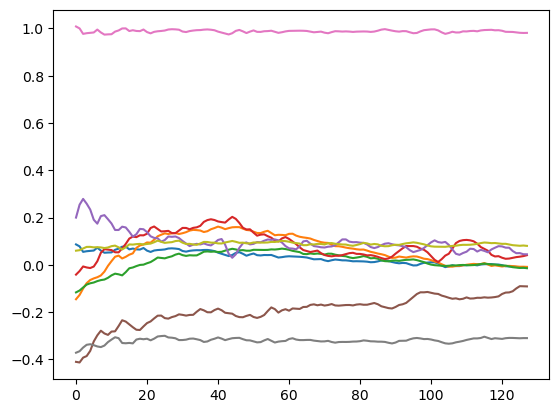

In [13]:
plt.plot(x[5]);

# **Model 🧠**

In [14]:
model = nn.Transformer(d_model=9,
                       nhead=3,
                       num_encoder_layers=3,
                       num_decoder_layers=3,
                       dim_feedforward=36,
                       dropout=0.2,
                       activation='gelu',
                       device='cuda')

model

/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=9, out_features=9, bias=True)
        )
        (linear1): Linear(in_features=9, out_features=36, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=36, out_features=9, bias=True)
        (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=9, out_features=9, bias=

In [15]:
model.encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=9, out_features=9, bias=True)
      )
      (linear1): Linear(in_features=9, out_features=36, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=36, out_features=9, bias=True)
      (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
)

In [16]:
model.decoder.layers[0].linear1.weight.shape

torch.Size([36, 9])

In [17]:
model = nn.Transformer(9, 3, 8, 0).encoder
model

TransformerEncoder(
  (layers): ModuleList(
    (0-7): 8 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=9, out_features=9, bias=True)
      )
      (linear1): Linear(in_features=9, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=9, bias=True)
      (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
)

In [18]:
encoder_layer = nn.TransformerEncoderLayer(d_model=9, nhead=3, dim_feedforward=36, device='cuda')

In [19]:
model = nn.TransformerEncoder(encoder_layer=encoder_layer,
                              num_layers=8)

model

TransformerEncoder(
  (layers): ModuleList(
    (0-7): 8 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=9, out_features=9, bias=True)
      )
      (linear1): Linear(in_features=9, out_features=36, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=36, out_features=9, bias=True)
      (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [20]:
model.layers[0].linear1.weight.device

device(type='cuda', index=0)

## HAR Model

In [21]:
class TransformerModel(nn.Module):

  def __init__(self, d_model, nhead, num_enc, d_feed, dropout, activation):
    super().__init__()
    self.encoder = nn.Transformer(d_model,
                                  nhead,
                                  num_enc,
                                  0,
                                  d_feed,
                                  dropout,
                                  activation,
                                  batch_first=True).encoder
    # cls
    self.fc = nn.LazyLinear(num_cls)
    # input layer
    self.linear0 = nn.LazyLinear(d_model)
    self.bn0 = nn.LazyBatchNorm1d()

  def forward(self, x):
    x = self.bn0(self.linear0(x)).relu()
    y = self.encoder(x)
    # y = y.mean(dim=1)
    y = self.fc(y[:, -1])
    # y = y.mean(dim=1)
    return y

In [26]:
model = TransformerModel(d_model=9, nhead=3 ,num_enc=8, d_feed=36, dropout=0.1, activation='relu')
model

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=9, out_features=9, bias=True)
        )
        (linear1): Linear(in_features=9, out_features=36, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=36, out_features=9, bias=True)
        (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
  )
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
  (linear0): LazyLinear(in_features=0, out_features=9, bias=True)
  (bn0): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [27]:
x.shape, model(x).shape

(torch.Size([256, 128, 9]), torch.Size([256, 6]))

## Params

In [28]:
def num_params(model, k=1e6):
  nums = sum(p.numel() for p in model.parameters())/k
  return nums

In [29]:
num_params(model, 1e6)

0.009136

# **Device ⚙️**

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [31]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [32]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [33]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_cls).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [34]:
model = TransformerModel(9, 3 , 8, 36, 0.1, 'relu').to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(1.9471, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [35]:
_, mini_train_dataset = random_split(train_set, (len(train_set) - 500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [36]:
model = TransformerModel(9, 3, 8, 36, 0.1, 'relu').to(device)
loss_fn = nn.CrossEntropyLoss()

In [37]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [38]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 28.57batch/s, accuracy=84, loss=0.392]  


## Step 3: select best lr

Train all data for one epoch

In [39]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = TransformerModel(9, 3, 8, 36, 0.1, 'relu').to(device)
  # model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LR=0.9


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.95batch/s, accuracy=18.1, loss=1.8] 



LR=0.5


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.10batch/s, accuracy=18.5, loss=1.79]



LR=0.2


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.98batch/s, accuracy=18.8, loss=1.78]



LR=0.1


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.01batch/s, accuracy=78, loss=0.468]  



LR=0.01


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.07batch/s, accuracy=68.7, loss=0.695]



LR=0.001


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.08batch/s, accuracy=19.5, loss=1.78]



LR=0.0001


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.01batch/s, accuracy=21.5, loss=1.8] 

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [40]:
num_epochs = 5

for lr in [0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]:
  for wd in [1e-4, 1e-5, 0.]:
    model = TransformerModel(9, 3, 8, 36, 0.1, 'relu').to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.05, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.98batch/s, accuracy=57.1, loss=1.04]



LR=0.05, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.98batch/s, accuracy=56, loss=0.873]  



LR=0.05, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.96batch/s, accuracy=59.1, loss=0.968]



LR=0.04, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.98batch/s, accuracy=56.2, loss=1.11]



LR=0.04, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.78batch/s, accuracy=51.2, loss=1.19]



LR=0.04, WD=0.0


Epoch 0:  83%|████████▎ | 24/29 [00:03<00:00,  6.48batch/s, accuracy=17.1, loss=1.85]


KeyboardInterrupt: 

## Step 5: train more epochs

In [41]:
model = TransformerModel(9, 3, 8, 36, 0.1, 'relu').to(device)

In [42]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [43]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [44]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'./model/model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 29/29 [00:04<00:00,  6.70batch/s, accuracy=33.5, loss=1.47]


Model Saved!
Valid: Loss = 1.37, Acc = 0.3115



Epoch 1: 100%|██████████| 29/29 [00:04<00:00,  7.07batch/s, accuracy=47.8, loss=1.18]


Model Saved!
Valid: Loss = 1.026, Acc = 0.5575



Epoch 2: 100%|██████████| 29/29 [00:04<00:00,  7.11batch/s, accuracy=61.3, loss=0.833]


Model Saved!
Valid: Loss = 0.8029, Acc = 0.6539



Epoch 3: 100%|██████████| 29/29 [00:04<00:00,  7.09batch/s, accuracy=70.9, loss=0.634]


Model Saved!
Valid: Loss = 0.5836, Acc = 0.7065



Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.10batch/s, accuracy=75.2, loss=0.536]


Valid: Loss = 0.6622, Acc = 0.6688



Epoch 5: 100%|██████████| 29/29 [00:04<00:00,  7.09batch/s, accuracy=76.5, loss=0.521]


Model Saved!
Valid: Loss = 0.5564, Acc = 0.7397



Epoch 6: 100%|██████████| 29/29 [00:04<00:00,  7.08batch/s, accuracy=78.5, loss=0.458]


Valid: Loss = 0.5973, Acc = 0.7173



Epoch 7: 100%|██████████| 29/29 [00:04<00:00,  7.06batch/s, accuracy=78.5, loss=0.45] 


Model Saved!
Valid: Loss = 0.495, Acc = 0.7601



Epoch 8: 100%|██████████| 29/29 [00:04<00:00,  6.96batch/s, accuracy=82.1, loss=0.405]


Valid: Loss = 0.5798, Acc = 0.7774



Epoch 9: 100%|██████████| 29/29 [00:04<00:00,  7.00batch/s, accuracy=84.7, loss=0.379]


Model Saved!
Valid: Loss = 0.4851, Acc = 0.7957



Epoch 10: 100%|██████████| 29/29 [00:04<00:00,  6.97batch/s, accuracy=87.3, loss=0.337]


Model Saved!
Valid: Loss = 0.4148, Acc = 0.8568



Epoch 11: 100%|██████████| 29/29 [00:04<00:00,  6.79batch/s, accuracy=86.7, loss=0.352]


Valid: Loss = 0.415, Acc = 0.8588



Epoch 12: 100%|██████████| 29/29 [00:04<00:00,  6.85batch/s, accuracy=88.4, loss=0.325]


Model Saved!
Valid: Loss = 0.4124, Acc = 0.8558



Epoch 13: 100%|██████████| 29/29 [00:04<00:00,  6.96batch/s, accuracy=87.9, loss=0.331]


Valid: Loss = 0.5629, Acc = 0.8398



Epoch 14: 100%|██████████| 29/29 [00:04<00:00,  6.99batch/s, accuracy=88.7, loss=0.308]


Valid: Loss = 0.5158, Acc = 0.8124



Epoch 15: 100%|██████████| 29/29 [00:04<00:00,  6.91batch/s, accuracy=90.8, loss=0.252]


Model Saved!
Valid: Loss = 0.3954, Acc = 0.8802



Epoch 16: 100%|██████████| 29/29 [00:04<00:00,  6.96batch/s, accuracy=87, loss=0.363]  


Valid: Loss = 0.598, Acc = 0.8473



Epoch 17: 100%|██████████| 29/29 [00:04<00:00,  6.74batch/s, accuracy=88.1, loss=0.373]


Valid: Loss = 0.4608, Acc = 0.8609



Epoch 18: 100%|██████████| 29/29 [00:04<00:00,  6.95batch/s, accuracy=91.5, loss=0.249]


Valid: Loss = 0.5399, Acc = 0.8534



Epoch 19: 100%|██████████| 29/29 [00:04<00:00,  6.99batch/s, accuracy=91, loss=0.258]  


Valid: Loss = 0.6031, Acc = 0.8636



# **Plot**

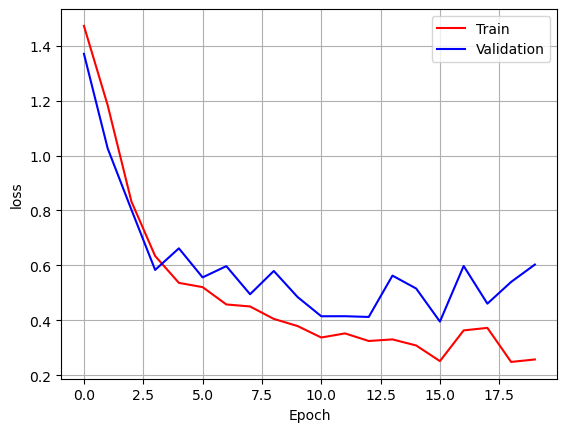

In [45]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

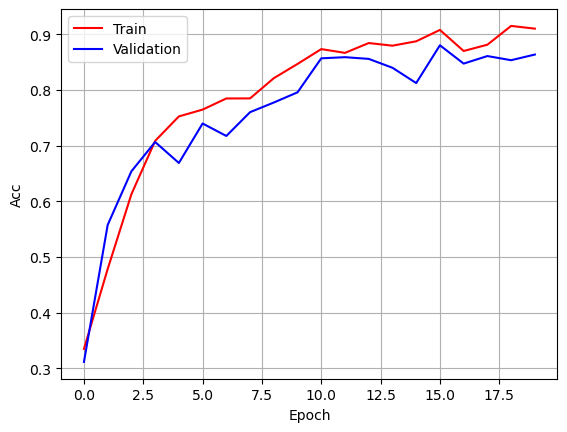

In [46]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()